In [361]:
# import packages 

import pandas as pd
import numpy as np 


import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

from nltk.corpus import stopwords

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import os, glob, sys, re, os, time
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Training Data Cleaning

In [362]:
# read in excel file
reddit = pd.read_excel("Relevant Reddit Posts.xlsx")

In [363]:
reddit.head()

,Text,Subreddit,Title,Author,Location,Created,Link,Theme,Protected Grounds
0,"When I got on the phone with them, they told m...",AskHR,Help!-racist comment said at work-complaint fi...,NaN,NaN,Mar 29 2020,https://www.reddit.com/r/AskHR/comments/frhe4y...,"racist coworker, micro-aggression, HR trouble","Race, Black"
1,I work at a small office. Most of us are clear...,Work,Should I ask HR for diversity training?,NaN,NaN,Oct 04 2018,https://www.reddit.com/r/work/comments/9ldyb5/...,"racist coworker, HR trouble, BLM","Race, Black"
2,Excited to have become the diversity and inclu...,AskHR,Have become diversity and inclusion lead at wo...,NaN,[UK],Jul 24 2020,https://www.reddit.com/r/AskHR/comments/hxaj1y...,"activist action, BLM, mega-threat","Race, Black"
3,Disclaimer I’m not posting this to shame my co...,AskHR,I shadowed a Co worker during a customer faced...,NaN,Houston Texas,Jul 20 2020,https://www.reddit.com/r/AskHR/comments/hkobea...,"HR trouble, racist coworker","Race, Asian, Black"
4,Hello fellow HR people! This is a weird questi...,AskHR,Washington State General Strike,NaN,Washington,Jun 09 2020,https://www.reddit.com/r/AskHR/comments/gzugri...,"activist action, HR trouble, BLM, mega-threat",Race


In [364]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 9 columns):
Text                 94 non-null object
Subreddit            94 non-null object
Title                94 non-null object
Author               71 non-null object
Location             11 non-null object
Created              93 non-null object
Link                 22 non-null object
Theme                93 non-null object
Protected Grounds    92 non-null object
dtypes: object(9)
memory usage: 6.7+ KB


In [365]:
reddit = reddit.rename(columns = {'Subreddit ': 'Subreddit'})

In [366]:
# remove whitespace before any themes after the comma 
reddit['Theme'] = reddit['Theme'].str.replace(", ", ",")

In [367]:
# generate dummies variables from unique values from the theme
topics = reddit['Theme'].str.get_dummies(',')
topics.head(20)

,BLM,HR trouble,activism action,activist action,blm,discrimination,diversity,iscrimination,mega-threat,micro-aggression,racist coworker
0,0,1,0,0,0,0,0,0,0,1,1
1,1,1,0,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,1
4,1,1,0,1,0,0,0,0,1,0,0
5,1,0,0,1,0,0,0,0,1,0,0
6,1,1,0,1,0,0,0,0,1,0,0
7,1,1,0,0,0,0,0,0,1,0,1
8,1,1,0,1,0,0,0,0,0,1,0
9,1,1,0,0,0,0,0,0,1,0,1


In [368]:
# combine BLM and blm; activism action and activist action columns
topics['BLM'] = topics['BLM'] + topics['blm']

topics['activist action'] = topics['activism action'] + topics['activist action']

topics['discrimination'] = topics['discrimination'] + topics['iscrimination']

topics_clean = topics.drop(columns = ['blm', 'activism action', 'iscrimination'])

topics_clean.head()

,BLM,HR trouble,activist action,discrimination,diversity,mega-threat,micro-aggression,racist coworker
0,0,1,0,0,0,0,1,1
1,1,1,0,0,0,0,0,1
2,1,0,1,0,0,1,0,0
3,0,1,0,0,0,0,0,1
4,1,1,1,0,0,1,0,0


In [369]:
# rename theme values to topic names
topics_clean = topics_clean.rename(columns = {col: 'topic'+'_{}'.format(col) for col in topics.columns}) 

topics_clean.head()

,topic_BLM,topic_HR trouble,topic_activist action,topic_discrimination,topic_diversity,topic_mega-threat,topic_micro-aggression,topic_racist coworker
0,0,1,0,0,0,0,1,1
1,1,1,0,0,0,0,0,1
2,1,0,1,0,0,1,0,0
3,0,1,0,0,0,0,0,1
4,1,1,1,0,0,1,0,0


In [370]:
# now we concate topics_clean back to reddit df 

reddit = reddit.join(topics_clean)
reddit.head()

,Text,Subreddit,Title,Author,Location,Created,Link,Theme,Protected Grounds,topic_BLM,topic_HR trouble,topic_activist action,topic_discrimination,topic_diversity,topic_mega-threat,topic_micro-aggression,topic_racist coworker
0,"When I got on the phone with them, they told m...",AskHR,Help!-racist comment said at work-complaint fi...,NaN,NaN,Mar 29 2020,https://www.reddit.com/r/AskHR/comments/frhe4y...,"racist coworker,micro-aggression,HR trouble","Race, Black",0,1,0,0,0,0,1,1
1,I work at a small office. Most of us are clear...,Work,Should I ask HR for diversity training?,NaN,NaN,Oct 04 2018,https://www.reddit.com/r/work/comments/9ldyb5/...,"racist coworker,HR trouble,BLM","Race, Black",1,1,0,0,0,0,0,1
2,Excited to have become the diversity and inclu...,AskHR,Have become diversity and inclusion lead at wo...,NaN,[UK],Jul 24 2020,https://www.reddit.com/r/AskHR/comments/hxaj1y...,"activist action,BLM,mega-threat","Race, Black",1,0,1,0,0,1,0,0
3,Disclaimer I’m not posting this to shame my co...,AskHR,I shadowed a Co worker during a customer faced...,NaN,Houston Texas,Jul 20 2020,https://www.reddit.com/r/AskHR/comments/hkobea...,"HR trouble,racist coworker","Race, Asian, Black",0,1,0,0,0,0,0,1
4,Hello fellow HR people! This is a weird questi...,AskHR,Washington State General Strike,NaN,Washington,Jun 09 2020,https://www.reddit.com/r/AskHR/comments/gzugri...,"activist action,HR trouble,BLM,mega-threat",Race,1,1,1,0,0,1,0,0


In [371]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 17 columns):
Text                      94 non-null object
Subreddit                 94 non-null object
Title                     94 non-null object
Author                    71 non-null object
Location                  11 non-null object
Created                   93 non-null object
Link                      22 non-null object
Theme                     93 non-null object
Protected Grounds         92 non-null object
topic_BLM                 94 non-null int64
topic_HR trouble          94 non-null int64
topic_activist action     94 non-null int64
topic_discrimination      94 non-null int64
topic_diversity           94 non-null int64
topic_mega-threat         94 non-null int64
topic_micro-aggression    94 non-null int64
topic_racist coworker     94 non-null int64
dtypes: int64(8), object(9)
memory usage: 12.6+ KB


### Data Cleaning - Text analysis 
- having post text as features using `CountVectorizer`

In [372]:
stop_words = stopwords.words('english')

stop_words.extend(['know', 'make', 'need', 'see', 'say', 'think', 'from', 'subject', 're', 'edu', 'use', 'people', 'going', 'even', 'just', 'still', 'really', 'many', 'thats', 'thing', 'actually', 'one', 'get' ])
stop_words.extend(['subreddit', 'im','dont','have', 'has', 'had', 'are', 'is', 'was', 'were', 'lot', 'lots', 'some', 'can', 'could', 'will', 'would', 'must', 'should', 'also', 'may', 'be'])
stop_words.extend(['question', 'ask','discuss','redditor', 'reddit', 'post','dedicate', 'discussion'])
vect_act = CountVectorizer(lowercase=False, min_df=50, max_df=0.6)


In [373]:
# removes numbers from text
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)
    return text

vect_text = CountVectorizer(min_df=3, max_df=0.9, ngram_range=(1, 3), stop_words=stop_words, 
                            preprocessor=preprocess_text)

In [374]:
text = reddit.Text
text_dtm = vect_text.fit_transform(text)
df_text = pd.DataFrame(text_dtm.toarray())
n_text=len(df_text. columns)+1
dict(zip(list(range(n_text)), vect_text.get_feature_names()))
df_text.rename(columns=dict(zip(list(range(n_text)), vect_text.get_feature_names())), inplace=True)


In [375]:
other = reddit[list(topics_clean.columns)]

In [376]:
DF = pd.concat([other, df_text], axis=1)
DF.head()

,topic_BLM,topic_HR trouble,topic_activist action,topic_discrimination,topic_diversity,topic_mega-threat,topic_micro-aggression,topic_racist coworker,As,BLM,...,world,worth,write,wrong,year,years,yes,yet,younger,youâ
0,0,1,0,0,0,0,1,1,0,0,...,0,0,1,1,0,0,5,0,0,0
1,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Topic_BLM

In [377]:
X = df_text
y = other['topic_BLM']

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# we don't have stratify parameter is because The stratify parameter set it to split data in a way to allocate 
# test_size amount of data to each class. In this case, you don't have sufficient class labels of one of your classes 
# to keep the data splitting ratio equal to test_size.

#### SVM model


CPU times: user 12.8 ms, sys: 47 µs, total: 12.8 ms
Wall time: 12.9 ms
Accuracy: 62.07%
              precision    recall  f1-score   support

           0       0.63      0.94      0.76        18
           1       0.50      0.09      0.15        11

   micro avg       0.62      0.62      0.62        29
   macro avg       0.56      0.52      0.45        29
weighted avg       0.58      0.62      0.53        29



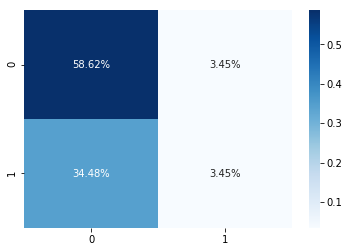

In [378]:
# import and instantiate a SVM model
from sklearn.svm import SVC

model = SVC(C=1, kernel='linear', probability=True )

model.fit(X_train, y_train)
%time model.fit(X_train, y_train)

# make predictions for test data
#%time y_pred = model.predict(X_test)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

#### Random Forest

CPU times: user 644 ms, sys: 268 ms, total: 912 ms
Wall time: 821 ms
CPU times: user 70.6 ms, sys: 15.4 ms, total: 86 ms
Wall time: 106 ms
Accuracy: 65.52%
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        18
           1       1.00      0.09      0.17        11

   micro avg       0.66      0.66      0.66        29
   macro avg       0.82      0.55      0.47        29
weighted avg       0.78      0.66      0.55        29



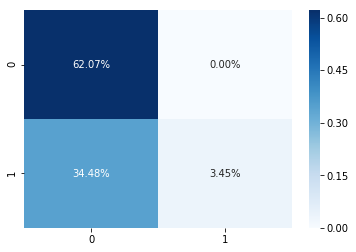

In [379]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators= 500, n_jobs=-1, max_depth=5, random_state=8, class_weight='balanced')

%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
cm=metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
cm
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

#### Multinomial Naive Bayes Model


CPU times: user 3.92 ms, sys: 1.74 ms, total: 5.66 ms
Wall time: 3.41 ms
CPU times: user 2.45 ms, sys: 2 µs, total: 2.45 ms
Wall time: 1.15 ms
Accuracy: 72.41%
              precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.71      0.45      0.56        11

   micro avg       0.72      0.72      0.72        29
   macro avg       0.72      0.67      0.68        29
weighted avg       0.72      0.72      0.71        29



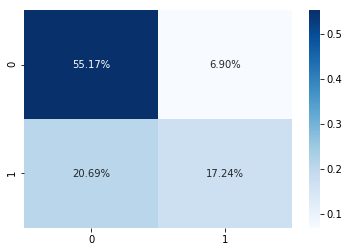

In [380]:
# fit a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha = 1)
%time model.fit(X_train, y_train)

# make predictions for test data
%time y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

### Multilabel Classification

In [381]:
# Random forest
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score

X1 = df_text
y1 = other
seed = 42
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=seed)

forest = RandomForestClassifier(n_estimators= 500, n_jobs=-1, max_depth=5, random_state=8, class_weight='balanced')

model_multi = MultiOutputClassifier(forest, n_jobs=-1)

%time model_multi.fit(X_train1, y_train1)

# make predictions for test data
%time y_pred1 = model_multi.predict(X_test1)


# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
y_test_p = y_test1.values

d = {}

for i in range(len(y1.columns)):
    d["auc_{0}".format(y1.columns[i])] = roc_auc_score(y_test_p[:,i], y_pred1[:,i])

d

CPU times: user 493 ms, sys: 40.1 ms, total: 533 ms
Wall time: 3.42 s
CPU times: user 2.12 s, sys: 76.2 ms, total: 2.2 s
Wall time: 2.74 s


{'auc_topic_BLM': 0.5454545454545454,
 'auc_topic_HR trouble': 0.6994949494949495,
 'auc_topic_activist action': 0.5714285714285714,
 'auc_topic_discrimination': 0.7559523809523809,
 'auc_topic_diversity': 0.5833333333333334,
 'auc_topic_mega-threat': 0.5615942028985508,
 'auc_topic_micro-aggression': 0.5,
 'auc_topic_racist coworker': 0.5}

In [382]:
# classification_report
from sklearn.metrics import classification_report

cr = {}

for i in range(len(y1.columns)):
     print("classfication report for\t"+"{}\n".format(y1.columns[i])+ classification_report(y_test_p[:,i], y_pred1[:,i]))

print()

classfication report for	topic_BLM
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        18
           1       1.00      0.09      0.17        11

   micro avg       0.66      0.66      0.66        29
   macro avg       0.82      0.55      0.47        29
weighted avg       0.78      0.66      0.55        29

classfication report for	topic_HR trouble
              precision    recall  f1-score   support

           0       0.74      0.94      0.83        18
           1       0.83      0.45      0.59        11

   micro avg       0.76      0.76      0.76        29
   macro avg       0.79      0.70      0.71        29
weighted avg       0.77      0.76      0.74        29

classfication report for	topic_activist action
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        22
           1       1.00      0.14      0.25         7

   micro avg       0.79      0.79      0.79        29
   m

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/p

In [383]:
# MNB
from sklearn.naive_bayes import MultinomialNB

X1 = df_text
y1 = other

seed = 42
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=seed)


mnb = MultinomialNB(alpha = 1)

model_multi = MultiOutputClassifier(mnb, n_jobs=-1)

%time model_multi.fit(X_train1, y_train1)

# make predictions for test data
%time y_pred1 = model_multi.predict(X_test1)


# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
y_test_p = y_test1.values

d = {}

for i in range(len(y1.columns)):
    d["auc_{0}".format(y1.columns[i])] = roc_auc_score(y_test_p[:,i], y_pred1[:,i])

d

CPU times: user 18.3 ms, sys: 3.15 ms, total: 21.4 ms
Wall time: 36.1 ms
CPU times: user 14.3 ms, sys: 2.19 ms, total: 16.5 ms
Wall time: 15.6 ms


{'auc_topic_BLM': 0.6717171717171717,
 'auc_topic_HR trouble': 0.8333333333333334,
 'auc_topic_activist action': 0.577922077922078,
 'auc_topic_discrimination': 0.6845238095238095,
 'auc_topic_diversity': 0.681159420289855,
 'auc_topic_mega-threat': 0.6014492753623187,
 'auc_topic_micro-aggression': 0.9642857142857143,
 'auc_topic_racist coworker': 0.5421052631578948}

In [384]:
from sklearn.metrics import classification_report

cr = {}

for i in range(len(y1.columns)):
     print("classfication report for\t"+"{}\n".format(y1.columns[i])+ classification_report(y_test_p[:,i], y_pred1[:,i]))

print()

classfication report for	topic_BLM
              precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.71      0.45      0.56        11

   micro avg       0.72      0.72      0.72        29
   macro avg       0.72      0.67      0.68        29
weighted avg       0.72      0.72      0.71        29

classfication report for	topic_HR trouble
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        18
           1       0.65      1.00      0.79        11

   micro avg       0.79      0.79      0.79        29
   macro avg       0.82      0.83      0.79        29
weighted avg       0.87      0.79      0.79        29

classfication report for	topic_activist action
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        22
           1       0.33      0.43      0.38         7

   micro avg       0.66      0.66      0.66        29
   m

#### Conclusion
It seems that MultinomialNB model does a better job at predicting posts that are BLM related; both in terms of accuracy measures and precision and recall measures. 

### Predicting Larger Dataset

In [385]:
df2_ = pd.read_csv("Reddit2k.csv")
df2_.head()

,text,subreddit,title,author,created
0,Yep. So far i would say if worst came to worst...,2020PoliceBrutality,Can we talk about this new âOperation Legend...,tacoim,2020-07-23 2:25
1,I feel so much fear and anxiety all the time. ...,2020PoliceBrutality,I need peace in my family. Anyone have any art...,Cham-Clowder,2020-07-20 11:04
2,Portland is going to skyrocket to the top agai...,2020PoliceBrutality,Wanted to give y'all an update on our count. C...,helicopter_corgi_mom,2020-07-18 0:34
3,Use the bubbling hate it generates to fund the...,2020PoliceBrutality,How do you cope with the emotions of subscribi...,seraphsrage,2020-07-12 23:24
4,I have recently rediscovered metal music. I lo...,2020PoliceBrutality,How do you cope with the emotions of subscribi...,kpolar,2020-07-15 7:49


# Import Manually Corrected Prediction

In [386]:
### Create a loop for previous versions 
n = 6

pred_accuracy = []

for i in range(1, n+1):
    # read in excel
    df_pm = pd.read_excel("Reddit_p{}.xlsx".format(i))
    
    # rename columns
    df_pm.columns = map(lambda x: str(x).title(), df_pm.columns)
    df_pm = df_pm.rename(columns = {"Topic_Blm" : "topic_BLM"})
    
    cols1 = list(set(reddit.columns).intersection(df_pm.columns))
    reddit_ = reddit[cols1]
    
    reddit = pd.concat([reddit_, df_pm], axis = 0, sort = True)
    reddit = reddit.drop(reddit.loc[reddit["Text"].isnull()].index)
    
    # generate text features
    text = reddit.Text
    text_dtm = vect_text.fit_transform(text)
    df_text = pd.DataFrame(text_dtm.toarray())
    n_text=len(df_text. columns)+1
    dict(zip(list(range(n_text)), vect_text.get_feature_names()))
    df_text.rename(columns=dict(zip(list(range(n_text)), vect_text.get_feature_names())), inplace=True)
    
    # train test spli
    X = df_text
    y = reddit['topic_BLM']

    seed = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    # fit a Multinomial Naive Bayes model
    from sklearn.naive_bayes import MultinomialNB
    model = MultinomialNB(alpha = 1)
    %time model.fit(X_train, y_train)

    # make predictions for test data
    %time y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    cm = metrics.confusion_matrix(y_test, y_pred)
    print(metrics.classification_report(y_test, y_pred))

    #sns.heatmap(cm/np.sum(cm), annot=True, 
    #        fmt='.2%', cmap='Blues')
    
    pred_accuracy.append(accuracy)

pred_accuracy

CPU times: user 2.33 ms, sys: 93 µs, total: 2.42 ms
Wall time: 2.31 ms
CPU times: user 2.77 ms, sys: 210 µs, total: 2.98 ms
Wall time: 1.28 ms
Accuracy: 65.91%
              precision    recall  f1-score   support

           0       0.82      0.62      0.71        29
           1       0.50      0.73      0.59        15

   micro avg       0.66      0.66      0.66        44
   macro avg       0.66      0.68      0.65        44
weighted avg       0.71      0.66      0.67        44

CPU times: user 5.82 ms, sys: 213 µs, total: 6.03 ms
Wall time: 2.02 ms
CPU times: user 2.84 ms, sys: 174 µs, total: 3.02 ms
Wall time: 1.11 ms
Accuracy: 72.88%
              precision    recall  f1-score   support

           0       0.88      0.62      0.72        34
           1       0.63      0.88      0.73        25

   micro avg       0.73      0.73      0.73        59
   macro avg       0.75      0.75      0.73        59
weighted avg       0.77      0.73      0.73        59

CPU times: user 4.39 ms, 

[0.6590909090909091,
 0.7288135593220338,
 0.6891891891891891,
 0.7640449438202247,
 0.7788461538461539,
 0.7238805970149254]

In [486]:
# add excel individually to the file 
df_pm = pd.read_excel("Reddit_p12.xlsx")

df_pm.head()

,text,subreddit,title,author,created,topic_BLM
0,This is how I feel from November to the end of...,ABoringDystopia,"My cousin asked me, a retail worker, how Black...",canteloupy,2019-11-30 7:20,0
1,OP sounds like an asshole. Cousin was making a...,ABoringDystopia,"My cousin asked me, a retail worker, how Black...",1sagas1,2019-11-30 12:13,0
2,"My family celebrated ""buy nothing day"" the day...",ABoringDystopia,"My cousin asked me, a retail worker, how Black...",KuriousKhemicals,2019-11-30 16:56,0
3,In N.Z and we had somewhat of a black friday s...,ABoringDystopia,"My cousin asked me, a retail worker, how Black...",toastismost,2019-12-01 20:39,0
4,how did i get here each day foreign yet famili...,ABoringDystopia,Aimless writing - Dark poem,dee-booder,2019-11-29 23:05,0


In [487]:
df_pm.columns = map(lambda x: str(x).title(), df_pm.columns)

df_pm = df_pm.rename(columns = {"Topic_Blm" : "topic_BLM"})
df_pm.head()

,Text,Subreddit,Title,Author,Created,topic_BLM
0,This is how I feel from November to the end of...,ABoringDystopia,"My cousin asked me, a retail worker, how Black...",canteloupy,2019-11-30 7:20,0
1,OP sounds like an asshole. Cousin was making a...,ABoringDystopia,"My cousin asked me, a retail worker, how Black...",1sagas1,2019-11-30 12:13,0
2,"My family celebrated ""buy nothing day"" the day...",ABoringDystopia,"My cousin asked me, a retail worker, how Black...",KuriousKhemicals,2019-11-30 16:56,0
3,In N.Z and we had somewhat of a black friday s...,ABoringDystopia,"My cousin asked me, a retail worker, how Black...",toastismost,2019-12-01 20:39,0
4,how did i get here each day foreign yet famili...,ABoringDystopia,Aimless writing - Dark poem,dee-booder,2019-11-29 23:05,0


In [488]:
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
Text         100 non-null object
Subreddit    100 non-null object
Title        100 non-null object
Author       97 non-null object
Created      100 non-null object
topic_BLM    100 non-null int64
dtypes: int64(1), object(5)
memory usage: 4.8+ KB


In [489]:
reddit.head()

,Author,Created,Subreddit,Text,Title,topic_BLM
0,NaN,Mar 29 2020,AskHR,"When I got on the phone with them, they told m...",Help!-racist comment said at work-complaint fi...,0
1,NaN,Oct 04 2018,Work,I work at a small office. Most of us are clear...,Should I ask HR for diversity training?,1
2,NaN,Jul 24 2020,AskHR,Excited to have become the diversity and inclu...,Have become diversity and inclusion lead at wo...,1
3,NaN,Jul 20 2020,AskHR,Disclaimer I’m not posting this to shame my co...,I shadowed a Co worker during a customer faced...,0
4,NaN,Jun 09 2020,AskHR,Hello fellow HR people! This is a weird questi...,Washington State General Strike,1


In [490]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 99
Data columns (total 6 columns):
Author       889 non-null object
Created      935 non-null object
Subreddit    936 non-null object
Text         936 non-null object
Title        936 non-null object
topic_BLM    936 non-null int64
dtypes: int64(1), object(5)
memory usage: 51.2+ KB


In [491]:
cols1 = list(set(reddit.columns).intersection(df_pm.columns))
reddit_ = reddit[cols1]
reddit_.head()

,Author,Created,topic_BLM,Text,Title,Subreddit
0,NaN,Mar 29 2020,0,"When I got on the phone with them, they told m...",Help!-racist comment said at work-complaint fi...,AskHR
1,NaN,Oct 04 2018,1,I work at a small office. Most of us are clear...,Should I ask HR for diversity training?,Work
2,NaN,Jul 24 2020,1,Excited to have become the diversity and inclu...,Have become diversity and inclusion lead at wo...,AskHR
3,NaN,Jul 20 2020,0,Disclaimer I’m not posting this to shame my co...,I shadowed a Co worker during a customer faced...,AskHR
4,NaN,Jun 09 2020,1,Hello fellow HR people! This is a weird questi...,Washington State General Strike,AskHR


In [492]:
reddit_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 99
Data columns (total 6 columns):
Author       889 non-null object
Created      935 non-null object
topic_BLM    936 non-null int64
Text         936 non-null object
Title        936 non-null object
Subreddit    936 non-null object
dtypes: int64(1), object(5)
memory usage: 51.2+ KB


In [493]:
reddit = pd.concat([reddit_, df_pm], axis = 0, sort = True)
reddit = reddit.drop(reddit.loc[reddit["Text"].isnull()].index)
reddit.head()

,Author,Created,Subreddit,Text,Title,topic_BLM
0,NaN,Mar 29 2020,AskHR,"When I got on the phone with them, they told m...",Help!-racist comment said at work-complaint fi...,0
1,NaN,Oct 04 2018,Work,I work at a small office. Most of us are clear...,Should I ask HR for diversity training?,1
2,NaN,Jul 24 2020,AskHR,Excited to have become the diversity and inclu...,Have become diversity and inclusion lead at wo...,1
3,NaN,Jul 20 2020,AskHR,Disclaimer I’m not posting this to shame my co...,I shadowed a Co worker during a customer faced...,0
4,NaN,Jun 09 2020,AskHR,Hello fellow HR people! This is a weird questi...,Washington State General Strike,1


In [494]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036 entries, 0 to 99
Data columns (total 6 columns):
Author       986 non-null object
Created      1035 non-null object
Subreddit    1036 non-null object
Text         1036 non-null object
Title        1036 non-null object
topic_BLM    1036 non-null int64
dtypes: int64(1), object(5)
memory usage: 56.7+ KB


## Re-Train Dataset

In [495]:
text = reddit.Text
text_dtm = vect_text.fit_transform(text)
df_text = pd.DataFrame(text_dtm.toarray())
n_text=len(df_text. columns)+1
dict(zip(list(range(n_text)), vect_text.get_feature_names()))
df_text.rename(columns=dict(zip(list(range(n_text)), vect_text.get_feature_names())), inplace=True)

In [496]:
df_text.head()

,ALL,Absolutely,Act,Actually,After,All,Also,Amazon,America,American,...,years ago,yes,yesterday,yet,young,younger,youtube,youâ,youâ saying,zero
0,0,0,0,0,0,0,0,0,0,2,...,0,5,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [497]:
X = df_text
y = reddit['topic_BLM']

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

CPU times: user 22.5 ms, sys: 22.2 ms, total: 44.7 ms
Wall time: 73.2 ms
CPU times: user 16.9 ms, sys: 4.95 ms, total: 21.9 ms
Wall time: 13.3 ms
Accuracy: 75.56%
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       199
           1       0.64      0.75      0.69       112

   micro avg       0.76      0.76      0.76       311
   macro avg       0.74      0.75      0.74       311
weighted avg       0.77      0.76      0.76       311



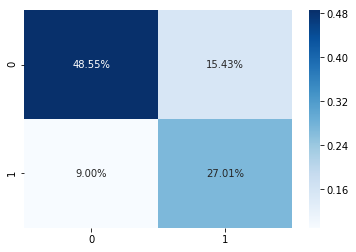

In [498]:
# fit a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha = 1)
%time model.fit(X_train, y_train)

# make predictions for test data
%time y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

In [480]:
df2 = df2_.iloc[950:1050].reset_index().drop(columns = 'index')
df2.head()

,text,subreddit,title,author,created
0,This is how I feel from November to the end of...,ABoringDystopia,"My cousin asked me, a retail worker, how Black...",canteloupy,2019-11-30 7:20
1,OP sounds like an asshole. Cousin was making a...,ABoringDystopia,"My cousin asked me, a retail worker, how Black...",1sagas1,2019-11-30 12:13
2,"My family celebrated ""buy nothing day"" the day...",ABoringDystopia,"My cousin asked me, a retail worker, how Black...",KuriousKhemicals,2019-11-30 16:56
3,In N.Z and we had somewhat of a black friday s...,ABoringDystopia,"My cousin asked me, a retail worker, how Black...",toastismost,2019-12-01 20:39
4,how did i get here each day foreign yet famili...,ABoringDystopia,Aimless writing - Dark poem,dee-booder,2019-11-29 23:05


In [481]:
text2 = df2.text
text_dtm2 = vect_text.fit_transform(text2)
df_text2 = pd.DataFrame(text_dtm2.toarray())
n_text2 = len(df_text2. columns)+1
dict(zip(list(range(n_text2)), vect_text.get_feature_names()))
df_text2.rename(columns=dict(zip(list(range(n_text2)), vect_text.get_feature_names())), inplace=True)
df_text2.head()

,American,And,Black,Black Friday,But,Can,Friday,If,In,It,...,word,work,worked,workers,working,works,world,wrong,www,years
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [482]:
# select overlapping text columns

cols_inter = list(set(df_text.columns).intersection(df_text2.columns))

df_text2_inter = df_text2[cols_inter]


# find df_text complement set

cols_com = list(set(df_text.columns) - set(df_text2.columns))

df_text2_com = pd.DataFrame(0, index=np.arange(len(df_text2)), columns=cols_com, dtype = int)

Xp = pd.concat([df_text2_inter, df_text2_com], axis = 1)
Xp.head()

,longer,whole,shit,What,family,cops,money,near,leave,employees,...,corporations,minority,Check,San,Jesus,firefighters,serve,maximum,purpose,Sounds like
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [483]:
y_pred = model.predict(Xp)


df2['topic_BLM'] = pd.Series(y_pred)

df2.head()

,text,subreddit,title,author,created,topic_BLM
0,This is how I feel from November to the end of...,ABoringDystopia,"My cousin asked me, a retail worker, how Black...",canteloupy,2019-11-30 7:20,1
1,OP sounds like an asshole. Cousin was making a...,ABoringDystopia,"My cousin asked me, a retail worker, how Black...",1sagas1,2019-11-30 12:13,1
2,"My family celebrated ""buy nothing day"" the day...",ABoringDystopia,"My cousin asked me, a retail worker, how Black...",KuriousKhemicals,2019-11-30 16:56,1
3,In N.Z and we had somewhat of a black friday s...,ABoringDystopia,"My cousin asked me, a retail worker, how Black...",toastismost,2019-12-01 20:39,1
4,how did i get here each day foreign yet famili...,ABoringDystopia,Aimless writing - Dark poem,dee-booder,2019-11-29 23:05,1


In [484]:
df2['topic_BLM']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    0
12    0
13    0
14    1
15    1
16    1
17    1
18    0
19    1
20    0
21    1
22    0
23    1
24    1
25    1
26    1
27    1
28    1
29    1
     ..
70    1
71    1
72    1
73    0
74    0
75    1
76    1
77    1
78    1
79    1
80    1
81    0
82    1
83    1
84    1
85    0
86    1
87    1
88    0
89    1
90    1
91    1
92    1
93    0
94    1
95    1
96    1
97    1
98    1
99    1
Name: topic_BLM, Length: 100, dtype: int64

In [485]:
df2.to_excel("Reddit_p12.xlsx", index = False)